In [41]:
# imports
##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from scipy.sparse import coo_matrix, hstack

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

import tqdm
from tqdm import trange

In [2]:
# Read in the data
##
tweets = pd.read_csv("csv files/tweets.csv")

In [3]:
# Preview data
##
tweets.head()

,tweet_id,text,created_at,likes,text length,polarity
0,1242123434466979841,everyday might good there always something goo...,2020-03-23 16:17:58,1,57,0.4
1,1242123396684697603,next one week,2020-03-23 16:17:49,0,13,0.0
2,1242123373188124673,imagine people coming self something h,2020-03-23 16:17:44,0,38,0.0
3,1242086219519012867,never forget remind fight corona,2020-03-23 13:50:06,0,32,0.0
4,1242123367882330113,they provide food outdoor step well quarante,2020-03-23 16:17:43,0,44,0.0


In [4]:
tweets.tail()

,tweet_id,text,created_at,likes,text length,polarity
1185,1242064075405905921,emergency response team sent trace catholic pr...,2020-03-23 12:22:06,4,73,0.113636
1186,1242064012797530112,time put mandatory hate happening,2020-03-23 12:21:51,1,33,-0.800000
1187,1242063970632163329,people lose trust governing becomes face choice,2020-03-23 12:21:41,1,47,0.000000
1188,1242063856727396352,incompetent wont die,2020-03-23 12:21:14,2,20,-0.350000
1189,1242063643883307008,next corona virus strain even deadly see lippi...,2020-03-23 12:20:23,1,58,-0.100000


# EDA
Exploring the data

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tweet_id     1190 non-null   int64  
 1   text         1182 non-null   object 
 2   created_at   1190 non-null   object 
 3   likes        1190 non-null   int64  
 4   text length  1190 non-null   int64  
 5   polarity     1190 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 55.9+ KB


In [6]:
tweets.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,1190.0,1.242092e+18,1.612207e+13,1.242064e+18,1.242078e+18,1.242092e+18,1.242103e+18,1.242123e+18
likes,1190.0,9.109244e-01,1.320269e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01
text length,1190.0,3.597059e+01,1.683447e+01,0.000000e+00,2.300000e+01,3.650000e+01,4.800000e+01,8.500000e+01
polarity,1190.0,5.597235e-02,2.477956e-01,-1.000000e+00,0.000000e+00,0.000000e+00,1.363636e-01,1.000000e+00


In [7]:
# Checking for missing data
##
if tweets.isnull().values.any() == True:
    print("There is missing data. \nThe missing data points are as follows:\n", tweets.isnull().sum())
else:
    print("There is no missing data points.")

There is missing data. 
The missing data points are as follows:
 tweet_id       0
text           8
created_at     0
likes          0
text length    0
polarity       0
dtype: int64


In [8]:
# Dropping the missing data points row-wise
##
tweets.dropna(axis=0, inplace=True)

In [9]:
# Reset index
##
tweets.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='text length', ylabel='Density'>

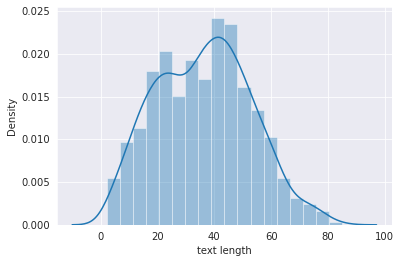

In [10]:
# Distribution of text length
##
sns.distplot(tweets['text length'])

In [11]:
# No. of unique number_of_likes and the corresponding count
##
tweets['likes'].value_counts()

0     587
1     341
2     150
3      49
4      31
6       8
5       6
7       4
10      2
8       2
11      1
9       1
Name: likes, dtype: int64

<AxesSubplot:xlabel='likes', ylabel='count'>

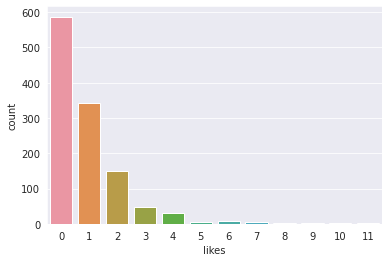

In [12]:
# Countplot of tweet likes
##
sns.countplot(x=tweets['likes'])

## Feature Engineering

In [13]:
# Let's classify sentiment as negative, neutral or positive
##
tweets['sentiment'] = np.nan

for i in trange(len(tweets)):
    if tweets['polarity'][i] < 0:
        tweets['sentiment'][i] = 'negative'
    elif tweets['polarity'][i] == 0:
        tweets['sentiment'][i] = 'neutral'
    else:
        tweets['sentiment'][i] = 'positive'

# Preview tweets
tweets.sample(15)

100%|██████████| 1182/1182 [00:00<00:00, 5916.47it/s]


,tweet_id,text,created_at,likes,text length,polarity,sentiment
1078,1242072342274154496,science prayer stop corona,2020-03-23 12:54:57,3,26,0.000000,neutral
381,1242105525032177664,forcing people stay home without blank stupid,2020-03-23 15:06:49,0,45,-0.400000,negative
1112,1242069364188340226,people working hard spread virus done nothing imp,2020-03-23 12:43:07,0,49,-0.291667,negative
803,1242090190161743874,issue government entire co sure priest,2020-03-23 14:05:52,0,38,0.250000,positive
1059,1242073540536471552,woman county forced quarante freely,2020-03-23 12:59:43,0,35,0.050000,positive
322,1242108011260362752,president supposed food faster got,2020-03-23 15:16:41,1,34,0.000000,neutral
303,1242108884401229826,branch lobby hand people handling money could,2020-03-23 15:20:09,0,45,0.000000,neutral
1097,1242070632352960513,dont know know take cannot bring,2020-03-23 12:48:09,0,32,0.000000,neutral
240,1242083121627107340,march president agreement look access,2020-03-23 13:37:47,0,37,0.000000,neutral
217,1242067323135111172,corona virus trying prove church service neces...,2020-03-23 12:35:00,0,57,0.000000,neutral


In [14]:
# Creating the target variable based off of the sentiment column
##
mapper = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}

tweets['target'] = tweets['sentiment'].map(mapper)

# Preview
tweets.sample(15)

,tweet_id,text,created_at,likes,text length,polarity,sentiment,target
1132,1242067004892332032,ever right time revolt civil disobedience thre...,2020-03-23 12:33:45,1,58,0.285714,positive,1
783,1242090930179579910,room measured negative quiet hear heartfelt,2020-03-23 14:08:49,2,43,-0.100000,negative,-1
995,1242078371888144387,thank percent live hand mouth need food,2020-03-23 13:18:55,0,39,0.136364,positive,1
296,1242109382340608000,without pray without go fine,2020-03-23 15:22:08,1,28,0.416667,positive,1
948,1242081484850241542,verily verily dying need,2020-03-23 13:31:17,1,24,0.000000,neutral,0
940,1242081999743078400,emergency response team sent trace catholic pr...,2020-03-23 13:33:20,1,73,0.113636,positive,1
687,1242094764683595776,one case admitted await,2020-03-23 14:24:03,0,23,0.000000,neutral,0
36,1242099069062914062,want start earning daily phone kindly send u c...,2020-03-23 14:41:09,0,52,0.300000,positive,1
820,1242089493257162753,anyone noted transaction course except,2020-03-23 14:03:06,0,38,0.000000,neutral,0
654,1242063741186904064,also concerned currently food house understand...,2020-03-23 12:20:46,0,60,0.000000,neutral,0


In [15]:
# Create another feature wordcount and compare its distribution with that of text length
# to see which best fits as a feature to be used in the model
##
tweets['word count'] = tweets['text'].apply(lambda text: len(text.split()))

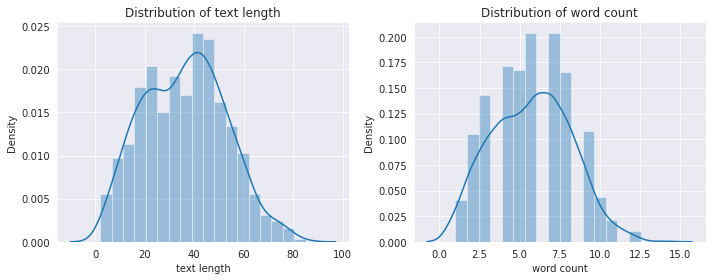

In [16]:
# Comparing the two distributions
##
fig, axes = plt.subplots(ncols=2, figsize=(10,4))

sns.distplot(tweets['text length'], ax=axes[0])
axes[0].set_title("Distribution of text length")

sns.distplot(tweets['word count'], ax=axes[1])
axes[1].set_title("Distribution of word count")

plt.tight_layout()

Seems that the two distributions have an identical pattern  
We'll use both features in the model building phase

In [17]:
tweets.head()

,tweet_id,text,created_at,likes,text length,polarity,sentiment,target,word count
0,1242123434466979841,everyday might good there always something goo...,2020-03-23 16:17:58,1,57,0.4,positive,1,9
1,1242123396684697603,next one week,2020-03-23 16:17:49,0,13,0.0,neutral,0,3
2,1242123373188124673,imagine people coming self something h,2020-03-23 16:17:44,0,38,0.0,neutral,0,6
3,1242086219519012867,never forget remind fight corona,2020-03-23 13:50:06,0,32,0.0,neutral,0,5
4,1242123367882330113,they provide food outdoor step well quarante,2020-03-23 16:17:43,0,44,0.0,neutral,0,7


## Model Building

In [18]:
# BOW (bag of words)
##
cv = CountVectorizer(analyzer='word')

cv.fit(tweets['text'])

CountVectorizer()

In [19]:
# Preview vocabulary and the number of vocab words
##
print(len(cv.vocabulary_))

1958


In [352]:
cv.vocabulary_

{'everyday': 580,
 'might': 1072,
 'good': 724,
 'there': 1724,
 'always': 58,
 'something': 1599,
 'day': 420,
 'could': 374,
 'next': 1142,
 'one': 1177,
 'week': 1893,
 'imagine': 828,
 'people': 1226,
 'coming': 322,
 'self': 1522,
 'never': 1139,
 'forget': 682,
 'remind': 1413,
 'fight': 641,
 'corona': 370,
 'they': 1726,
 'provide': 1340,
 'food': 669,
 'outdoor': 1190,
 'step': 1636,
 'well': 1897,
 'quarante': 1349,
 'like': 963,
 'said': 1480,
 'total': 1757,
 'shutdown': 1558,
 'bite': 190,
 'finger': 651,
 'since': 1570,
 'childhood': 290,
 'seen': 1519,
 'big': 180,
 'need': 1131,
 'testing': 1715,
 'army': 100,
 'threat': 1734,
 'national': 1122,
 'se': 1506,
 'wish': 1917,
 'would': 1941,
 'much': 1110,
 'presidential': 1300,
 'address': 19,
 'waiting': 1867,
 'today': 1748,
 'mass': 1038,
 'please': 1259,
 'way': 1888,
 'help': 778,
 'mean': 1047,
 'na': 1117,
 'cure': 399,
 'money': 1099,
 'anaemic': 67,
 'difficult': 464,
 'chose': 298,
 'dying': 515,
 'hunger': 817,

In [20]:
# Example transforming a single text
##
print(cv.transform([tweets['text'][0]]))

  (0, 58)	1
  (0, 374)	1
  (0, 420)	1
  (0, 580)	1
  (0, 724)	2
  (0, 1072)	1
  (0, 1599)	1
  (0, 1724)	1


In [21]:
# Example getting the feature name by index
##
cv.get_feature_names()[724]

'good'

In [22]:
# Transforming the whole BOW to a sparse matrix
##
bow_text = cv.transform(tweets['text'])

In [23]:
# Non-zero occurrences
##
bow_text.nnz

6455

In [24]:
# tfidf weighting
##
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(bow_text)

TfidfTransformer()

In [25]:
# Example transforming a single bow
##
print(tfidf_transformer.transform(cv.transform([tweets['text'][0]])))

  (0, 1724)	0.3537881182770148
  (0, 1599)	0.31966304511247007
  (0, 1072)	0.31025800282988647
  (0, 724)	0.5665166663853541
  (0, 580)	0.37661555463428
  (0, 420)	0.28325833319267707
  (0, 374)	0.1665231693082509
  (0, 58)	0.32502894965067836


In [26]:
# Example getting idf weight of a word
##
tfidf_transformer.idf_[cv.vocabulary_['good']]

5.0312864262549635

In [27]:
# Transforming the whole sparse matrix
##
tfidf_text = tfidf_transformer.transform(bow_text)

Adding 'text length' and 'word count' as features to the model  
We'll stack the features to the sparse matrix horizontally

In [28]:
"""# Transforming the two columns into sparse matrices
##
txt_length = coo_matrix(tweets['text length']).reshape(1182,1)
wrd_cnt = coo_matrix(tweets['word count']).reshape(1182,1)

features = hstack([tfidf_text, txt_length, wrd_cnt])

# Preview difference in shapes
print("Shape of text column sparse matrix: ", tfidf_text.shape)
print("Shape of concatenated features sparse matrix: ", features.shape)"""

'# Transforming the two columns into sparse matrices\n##\ntxt_length = coo_matrix(tweets[\'text length\']).reshape(1182,1)\nwrd_cnt = coo_matrix(tweets[\'word count\']).reshape(1182,1)\n\nfeatures = hstack([tfidf_text, txt_length, wrd_cnt])\n\n# Preview difference in shapes\nprint("Shape of text column sparse matrix: ", tfidf_text.shape)\nprint("Shape of concatenated features sparse matrix: ", features.shape)'

In [29]:
features = tfidf_text

## Comparing different classification models:  
- Logistic Regression
- Linear SVC (svm)
- Random Forest Classifier
- Xgboost Classifier

In [31]:
# Splitting data into train and test splits
##
X_train, X_test, y_train, y_test = train_test_split(features, tweets['target'], test_size=0.2)

In [32]:
# Initialize models
##
lr = LogisticRegression(C=2.0, class_weight=None, dual=False, max_iter=100)

svc = LinearSVC(C=2.0, class_weight=None, dual=False, max_iter=100)

rfc = RandomForestClassifier(bootstrap=False, class_weight=None, 
                             criterion='entropy', min_samples_split=6, n_estimators=160, warm_start=False)

xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

In [33]:
# Train models
##
lr.fit(X_train, y_train)

svc.fit(X_train, y_train)

rfc.fit(X_train, y_train)

xgb.fit(X_train,y_train)

[12:18:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
# Make predictions
##
lr_pred = lr.predict(X_test)

svc_pred = svc.predict(X_test)

rfc_pred = rfc.predict(X_test)

xgb_pred = xgb.predict(X_test)

In [35]:
# Evaluate models
##
print("Logistic Regression \n----------------------------------")
print(confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred))
print("Linear SVC \n---------------------------------")
print(confusion_matrix(y_test, svc_pred))
print(classification_report(y_test, svc_pred))
print("Random Forest Classifier \n----------------------------------")
print(confusion_matrix(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))
print("Xgboost Classifier \n----------------------------------")
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

Logistic Regression 
----------------------------------
[[  4  29   7]
 [  1 124   6]
 [  0  33  33]]
              precision    recall  f1-score   support

          -1       0.80      0.10      0.18        40
           0       0.67      0.95      0.78       131
           1       0.72      0.50      0.59        66

    accuracy                           0.68       237
   macro avg       0.73      0.52      0.52       237
weighted avg       0.70      0.68      0.63       237

Linear SVC 
---------------------------------
[[ 13  19   8]
 [  4 120   7]
 [  2  25  39]]
              precision    recall  f1-score   support

          -1       0.68      0.33      0.44        40
           0       0.73      0.92      0.81       131
           1       0.72      0.59      0.65        66

    accuracy                           0.73       237
   macro avg       0.71      0.61      0.63       237
weighted avg       0.72      0.73      0.71       237

Random Forest Classifier 
------------------

In [36]:
cross_val_score(xgb, features, tweets['target'], cv=5)

[12:18:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

array([0.72151899, 0.7257384 , 0.74152542, 0.72033898, 0.69915254])

In [37]:
# Making sure that the models are not overfitting using cross val score metric with 5 folds
##
print("Logistic Regression \n------------------------- \nscore= ", cross_val_score(lr, features, tweets['target'], cv=5).mean())
print("\nLinear SVC \n------------------------- \nscore=", cross_val_score(svc, features, tweets['target'], cv=5).mean())
print("\nRandom Forest Classifier \n------------------------- \nscore=", cross_val_score(rfc, features, tweets['target'], cv=5).mean())
print("\nXgboost Classifier \n------------------------- \nscore=", cross_val_score(xgb, features, tweets['target'], cv=5).mean())

Logistic Regression 
------------------------- 
score=  0.6928913680898233

Linear SVC 
------------------------- 
score= 0.7284416791818638

Random Forest Classifier 
------------------------- 
score= 0.7563291139240507
[12:19:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:16] WARNING: 

In [38]:
# Random forest performed best
# That's a good score having in mind that the model is attempting to predict between three category classes

In [48]:
# saving model
from sklearn.pipeline import Pipeline
import pickle

# retrain
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', RandomForestClassifier(
    bootstrap=False, class_weight=None, criterion='entropy', min_samples_split=6,
    n_estimators=160, warm_start=False))])
pipe.fit(tweets.text, tweets.target)
pickle.dump(pipe, open('saved_model.pkl', 'wb'))

In [49]:
np.int(pipe.predict(["I love people."]))

1